In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

### Load data

In [2]:
df = pd.read_parquet('/home/foolingeng/ruien/data/grab-posisi/sg/trip_info_sg.parquet')
df = df.reset_index(drop=True)

### Convert datetime data

In [3]:
df['start_hour'] = df['start_time'].dt.hour
df['start_minute'] = df['start_time'].dt.minute
df['end_hour'] = df['end_time'].dt.hour
df['end_minute'] = df['end_time'].dt.minute

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279768 entries, 0 to 279767
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   trj_id                279768 non-null  object        
 1   driving_mode          279768 non-null  object        
 2   osname                279768 non-null  object        
 3   start_time            279768 non-null  datetime64[ns]
 4   end_time              279768 non-null  datetime64[ns]
 5   eta                   279768 non-null  int64         
 6   start_lat             279768 non-null  float64       
 7   end_lat               279768 non-null  float64       
 8   start_lng             279768 non-null  float64       
 9   end_lng               279768 non-null  float64       
 10  time_of_day           279768 non-null  int64         
 11  day_of_week           279768 non-null  int64         
 12  avg_speed             279768 non-null  float64       
 13 

### Multicolinearity

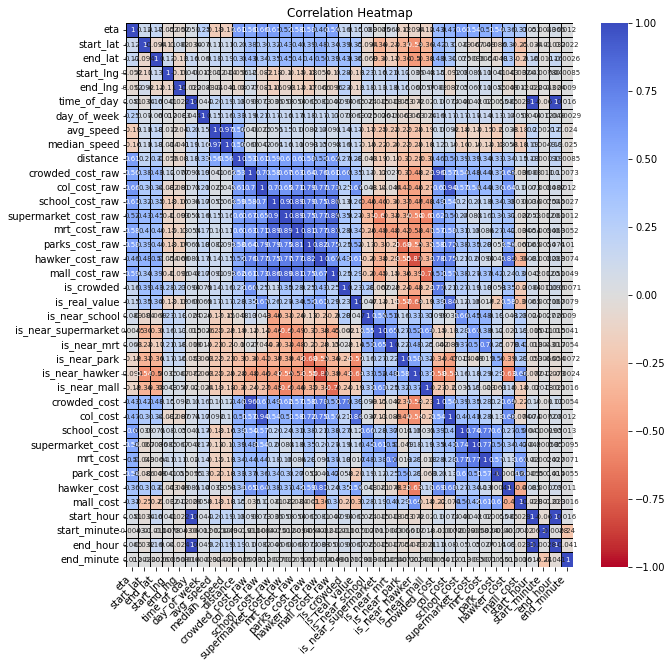

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

# Correlation heatmap
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [21]:
# Multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_table = calc_vif(df.drop([
    'eta', 'time_of_day', 'start_hour', 'end_hour', 'start_minute', 'end_minute',
    'crowded_cost_raw', 'school_cost_raw', 'supermarket_cost_raw', 'mrt_cost_raw', 
    'parks_cost_raw', 'hawker_cost_raw', 'col_cost_raw', 'crowded_cost_raw'], axis=1)
   .select_dtypes(include=['int64','float64']))

In [20]:
vif_table

,variables,VIF,tolerance,meanVIF
0,start_lat,2.520084e+03,3.968121e-04,85734.154124
1,end_lat,2.722593e+03,3.672969e-04,85734.154124
2,start_lng,1.025283e+06,9.753401e-07,85734.154124
3,end_lng,1.025843e+06,9.748085e-07,85734.154124
4,day_of_week,3.699669e+00,2.702944e-01,85734.154124
5,avg_speed,2.865261e+02,3.490083e-03,85734.154124
6,median_speed,2.291122e+02,4.364674e-03,85734.154124
7,distance,4.385429e+01,2.280278e-02,85734.154124
8,mall_cost_raw,5.205613e+01,1.921003e-02,85734.154124
9,is_crowded,2.542967e+01,3.932415e-02,85734.154124


### Check for normality

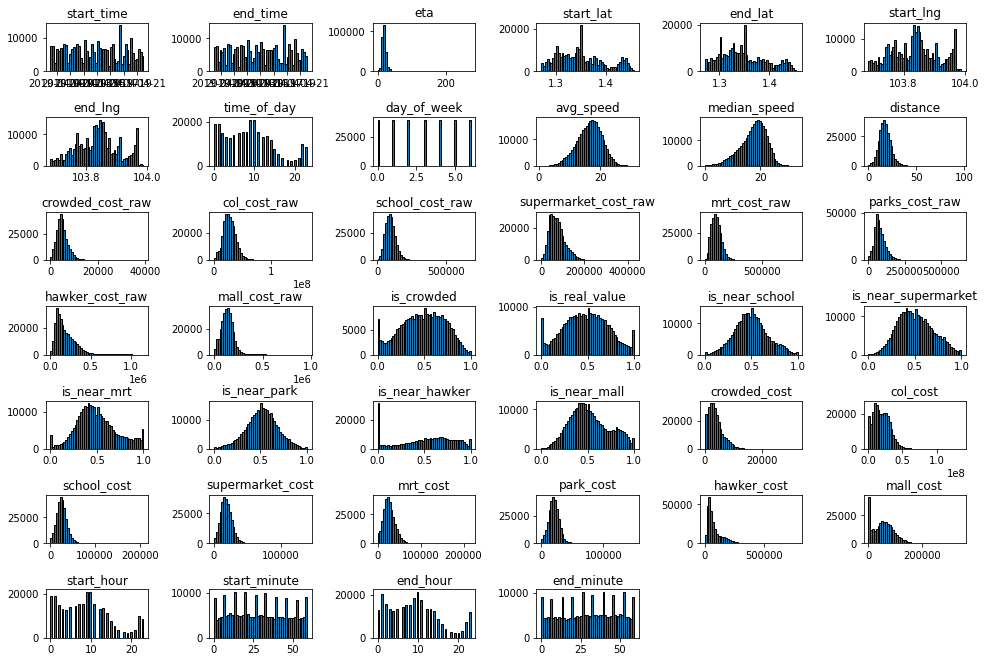

In [16]:
df.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

### Outlier detection

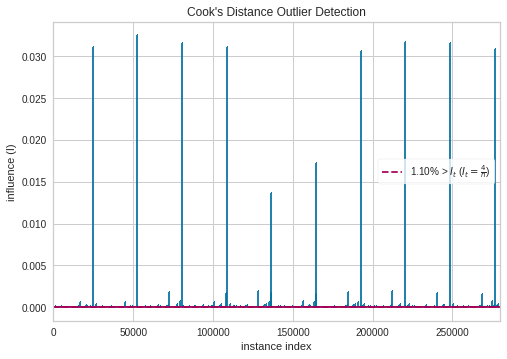

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [6]:
from yellowbrick.regressor import CooksDistance

def get_cook_distance_plot(df: pd.DataFrame):
    df_y = df['eta']
    df_X = df.drop(['eta'], axis=1).select_dtypes(include=['int64','float64'])
    visualizer = CooksDistance()
    visualizer.fit(df_X.values, df_y)
    return visualizer

visualiser = get_cook_distance_plot(df)
visualiser.show()

(276704,) (276704, 37) (279768, 43)


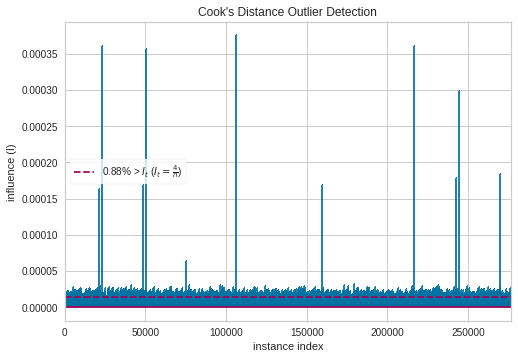

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [7]:
i_less_influential = (visualiser.distance_ <= visualiser.influence_threshold_)

df_y_li = df['eta'][i_less_influential]
df_X_li = df[i_less_influential].drop(['eta'], axis=1).select_dtypes(include=['int64','float64'])
print(df_y_li.shape, df_X_li.shape, df.shape)

visualiser = CooksDistance()
visualiser.fit(df_X_li.values, df_y_li)
visualiser.show()

### Split Dataset

In [8]:
df_cleaned = df[i_less_influential]
print('cleaned', df_cleaned.shape, 'raw', df.shape)

train_size = int(0.8 * df_cleaned.shape[0])
df_train = df_cleaned.loc[:train_size, :]
df_test = df_cleaned.loc[train_size:, :]

train_features = [
    # 'driving_mode', 'start_time', 'end_time',
    'start_hour', 'start_minute',
    'start_lat', 'end_lat', 'start_lng', 'end_lng', 'time_of_day',
    'day_of_week', 'avg_speed', 'median_speed', 'distance',
    'crowded_cost_raw', 'col_cost_raw', 'school_cost_raw',
    'supermarket_cost_raw', 'mrt_cost_raw', 'parks_cost_raw',
    'hawker_cost_raw', 'mall_cost_raw', 'is_crowded', 'is_real_value',
    'is_near_school', 'is_near_supermarket', 'is_near_mrt', 'is_near_park',
    'is_near_hawker', 'is_near_mall', 'crowded_cost', 'col_cost',
    'school_cost', 'supermarket_cost', 'mrt_cost', 'park_cost',
    'hawker_cost', 'mall_cost']
target_feature = 'eta'

x_train = df_train[train_features]
y_train = df_train[target_feature]
x_test = df_test[train_features]
y_test = df_test[target_feature]

df_train.shape, df_test.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

cleaned (276704, 43) raw (279768, 43)


((218935, 43), (57770, 43), (218935, 35), (218935,), (57770, 35), (57770,))

### Preprocessing

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)

x_train_transformed = scaler.transform(x_train)
x_test_transformed = scaler.transform(x_test)
x_train_transformed.shape, x_test_transformed.shape
x_train_transformed

array([[ 0.34341833, -0.17137756, -1.05473169, ...,  1.12441929,
        -0.96472921,  2.86533847],
       [-1.10517752,  0.88172841, -0.12992906, ..., -0.42370002,
        -0.77365566,  0.77987407],
       [-1.42708771,  1.17425784,  1.8199718 , ..., -1.40237587,
        -0.9655104 , -1.24201194],
       ...,
       [ 2.11392437,  0.06264599, -0.33389543, ..., -0.09077033,
        -0.38828282, -0.32393725],
       [ 1.14819381, -0.40540111, -1.39840781, ...,  0.27122323,
        -0.92256623, -0.1153641 ],
       [-1.26613261,  0.53069308, -0.403023  , ..., -0.70756184,
        -0.10041229,  0.02532622]])

### Hyperparameter tuning

In [111]:
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [127, 255]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(x_train_transformed, y_train)

print(f'Best parameters found by grid search are: {gbm.best_params_}')

Best parameters found by grid search are: {'learning_rate': 0.3, 'n_estimators': 255}


### Train

In [13]:
gbm = lgb.LGBMRegressor(num_leaves=127,
                        learning_rate=0.3,
                        n_estimators=255,
                        reg_lambda=1e-3,
                        boosting_type='gbdt')

gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(5)])

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's l2: 1.42286


LGBMRegressor(learning_rate=0.3, n_estimators=255, num_leaves=127,
              reg_lambda=0.001)

In [11]:
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 255,
 'n_jobs': -1,
 'num_leaves': 127,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.001,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [12]:
x_train.columns

Index(['start_hour', 'start_minute', 'start_lat', 'end_lat', 'start_lng',
       'end_lng', 'time_of_day', 'day_of_week', 'avg_speed', 'median_speed',
       'distance', 'crowded_cost_raw', 'col_cost_raw', 'school_cost_raw',
       'supermarket_cost_raw', 'mrt_cost_raw', 'parks_cost_raw',
       'hawker_cost_raw', 'mall_cost_raw', 'is_crowded', 'is_real_value',
       'is_near_school', 'is_near_supermarket', 'is_near_mrt', 'is_near_park',
       'is_near_hawker', 'is_near_mall', 'crowded_cost', 'col_cost',
       'school_cost', 'supermarket_cost', 'mrt_cost', 'park_cost',
       'hawker_cost', 'mall_cost'],
      dtype='object')

In [ ]:
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=['start_hour', 'start_lat', 'day_of_week'])
num_round = 10
# model = lgb.train(gbm.get_params(), train_data, num_round, valid_sets=[val_data])
outputs = lgb.cv(gbm.get_params(), train_data, num_round, nfold=5)

### Evaluation

In [14]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

# feature importances
print(f'Feature importances: {list(gbm.feature_importances_)}')

y_pred, y_test

The RMSE of prediction is: 1.1928373020511296
Feature importances: [1400, 2108, 2134, 1898, 2012, 1865, 0, 920, 1550, 1157, 2087, 503, 470, 494, 451, 512, 499, 497, 460, 862, 767, 817, 749, 835, 791, 774, 808, 564, 478, 627, 549, 595, 572, 695, 630]


(array([15.68892334, 21.51362111, 20.39360472, ..., 19.51772511,
        20.24128161, 14.20845396]),
 221363    15
 221364    23
 221365    19
 221366    20
 221367    19
           ..
 279763    19
 279764    29
 279765    20
 279766    18
 279767    15
 Name: eta, Length: 57770, dtype: int64)

<AxesSubplot:title={'center':'Split value histogram for feature with name distance'}, xlabel='Feature split value', ylabel='Count'>

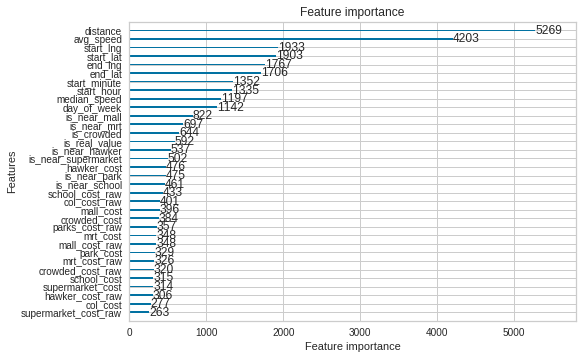

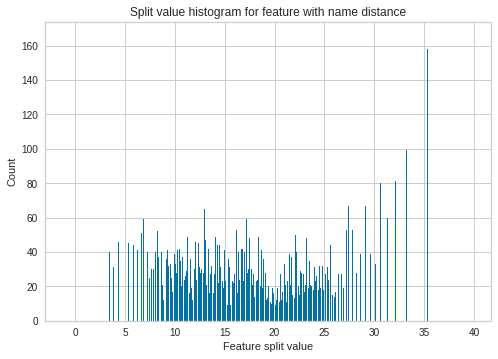

In [11]:
lgb.plot_importance(gbm)
lgb.plot_split_value_histogram(gbm, 'distance')